In [1]:
import numpy as np
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Conv2DTranspose, RandomFlip, RandomRotation, RandomZoom, Dense, MaxPool2D, Concatenate, BatchNormalization, Dropout, UpSampling2D, Lambda, Input, Flatten, Reshape, Layer, Activation
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.data import AUTOTUNE

In [2]:
strategy = tf.distribute.MirroredStrategy()
base_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
BATCH_SIZE = 8 * 2

In [3]:
def get_image_mask_pairs():
    
    pairs = []
    
    for root, dirs, files in os.walk(base_dir):
        img_files = [f for f in files if f.endswith('.tif') and '_mask' not in f]
        
        for img_file in img_files:
            img_path = os.path.join(root, img_file)
            mask_file = img_file.replace('.tif', '_mask.tif')
            mask_path = os.path.join(root, mask_file)
            
            if os.path.exists(mask_path):
                pairs.append((img_path, mask_path))
    
    print(f"Found {len(pairs)} image-mask pairs")
    
    return pairs


In [4]:
def load_and_preprocess(image_path, mask_path):
    
    # Convert TensorFlow tensors to Python strings
    img_path = image_path.numpy().decode('utf-8')
    msk_path = mask_path.numpy().decode('utf-8')
    
    # Open and convert images to numpy arrays
    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(msk_path))
    
    # Convert grayscale images to RGB if needed
    if len(image.shape) == 2:
        image = np.stack([image, image, image], axis=-1)
    
    # Ensure mask is 2D (grayscale)
    if len(mask.shape) > 2:
        mask = mask[:, :, 0]  
    
    # Add channel dimension to mask (256, 256, 1)
    mask = mask[:, :, np.newaxis]
    
    image = tf.image.resize(image, [256, 256])
    mask = tf.image.resize(mask, [256, 256])
    
    # Normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    
    # Return as tensors directly
    return image, mask

In [5]:
def create_train_val_test_dataset(train_split=0.8, val_split=0.1, test_split=0.1, batch_size = BATCH_SIZE):
        
    # Get all pairs and shuffle them
    pairs = get_image_mask_pairs()
    np.random.shuffle(pairs)
    
    # Compute indices for splits
    n = len(pairs)
    train_end = int(n * train_split)
    val_end = train_end + int(n * val_split)
    
    train_pairs = pairs[:train_end]
    val_pairs = pairs[train_end:val_end]
    test_pairs = pairs[val_end:]
    
    print(f"Training pairs: {len(train_pairs)}")
    print(f"Validation pairs: {len(val_pairs)}")
    print(f"Test pairs: {len(test_pairs)}")
    
    # Helper function to create a dataset from pairs
    def create_dataset_from_pairs(pairs, is_training=False):
        image_paths = tf.constant([p[0] for p in pairs])
        mask_paths = tf.constant([p[1] for p in pairs])
        
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
        
        if is_training:
            # Shuffle with a buffer size limited to the number of pairs
            buffer_size = min(len(pairs), 1000)
            dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=True)
        
        dataset = dataset.map(
            lambda img_path, mask_path: tf.py_function(
                func=load_and_preprocess,
                inp=[img_path, mask_path],
                Tout=[tf.float32, tf.float32]
            ),
            num_parallel_calls=AUTOTUNE
        )
        
        # Explicitly set shape for images and masks
        dataset = dataset.map(
            lambda img, mask: (
                tf.ensure_shape(img, [256, 256, 3]), 
                tf.ensure_shape(mask, [256, 256, 1])
            ),
            num_parallel_calls=AUTOTUNE
        )
        
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(AUTOTUNE)
        return dataset
    
    # Create datasets for each split
    train_dataset = create_dataset_from_pairs(train_pairs, is_training=True)
    val_dataset = create_dataset_from_pairs(val_pairs, is_training=False)
    test_dataset = create_dataset_from_pairs(test_pairs, is_training=False)
    
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = create_train_val_test_dataset(train_split=0.8, val_split=0.1, test_split=0.1, batch_size=8)

Found 3929 image-mask pairs
Training pairs: 3143
Validation pairs: 392
Test pairs: 394


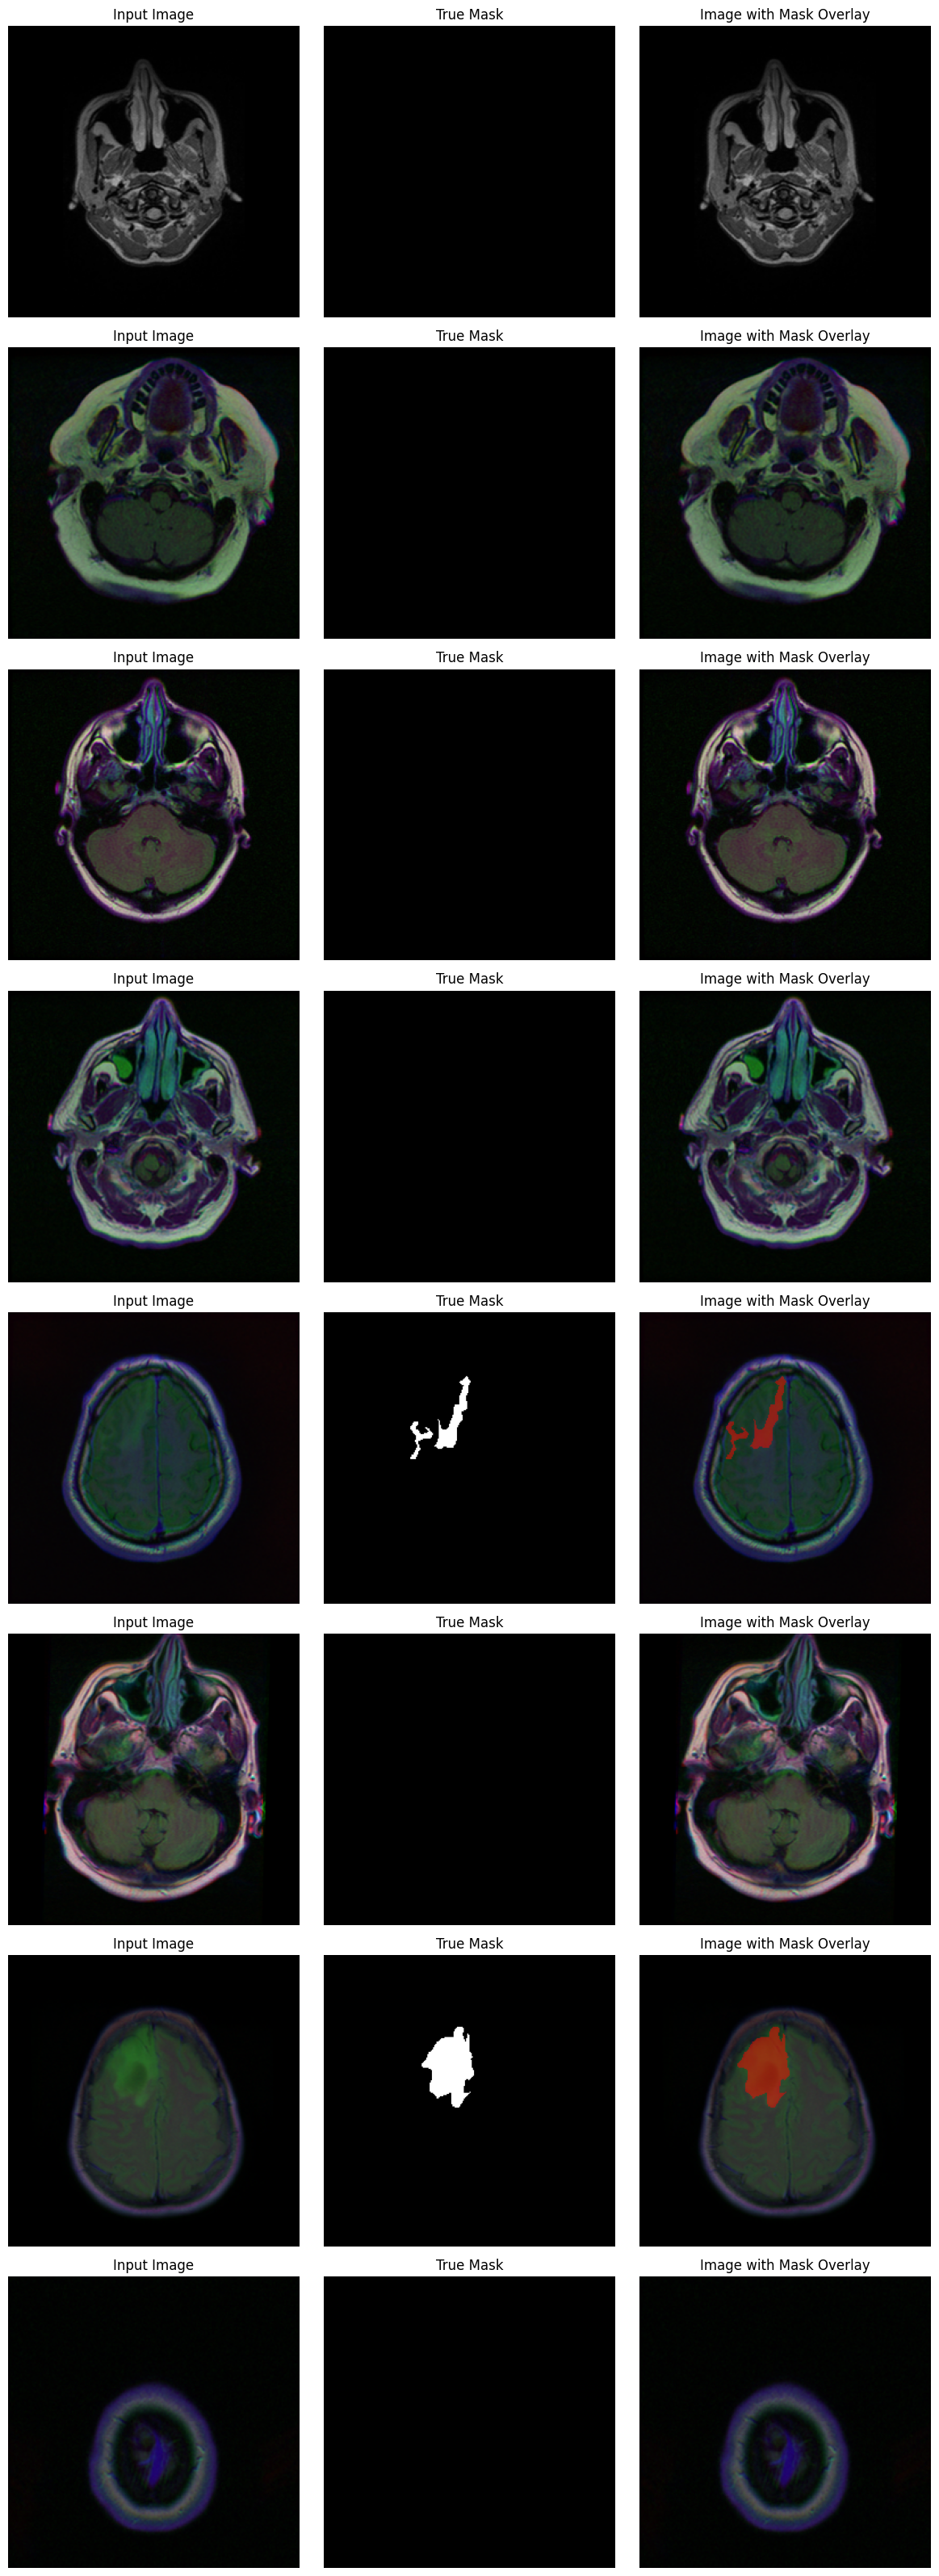

In [6]:

def display_sample(display_list):
    plt.figure(figsize=(12, 4 * len(display_list[0])))
    
    for i in range(len(display_list[0])):
        plt.subplot(len(display_list[0]), 3, i*3 + 1)
        plt.title('Input Image')
        plt.imshow(display_list[0][i])
        plt.axis('off')
        
        plt.subplot(len(display_list[0]), 3, i*3 + 2)
        plt.title('True Mask')
        plt.imshow(tf.squeeze(display_list[1][i]), cmap='gray')
        plt.axis('off')
        
        # Overlay mask on image
        plt.subplot(len(display_list[0]), 3, i*3 + 3)
        plt.title('Image with Mask Overlay')
        img = display_list[0][i].numpy()
        mask = tf.squeeze(display_list[1][i]).numpy()
        
        # Create RGB mask for overlay (red channel)
        mask_rgb = np.zeros_like(img)
        mask_rgb[:, :, 0] = mask * 1.0  # Red channel
        
        # Blend image with mask
        alpha = 0.5
        mask_3d = np.expand_dims(mask, axis=-1)  # Shape becomes (256, 256, 1)
        blended = alpha * mask_rgb + (1 - alpha * mask_3d) * img
        plt.imshow(blended)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
# Display samples from first batch
for images, masks in train_dataset.take(1):
    display_sample([images, masks])


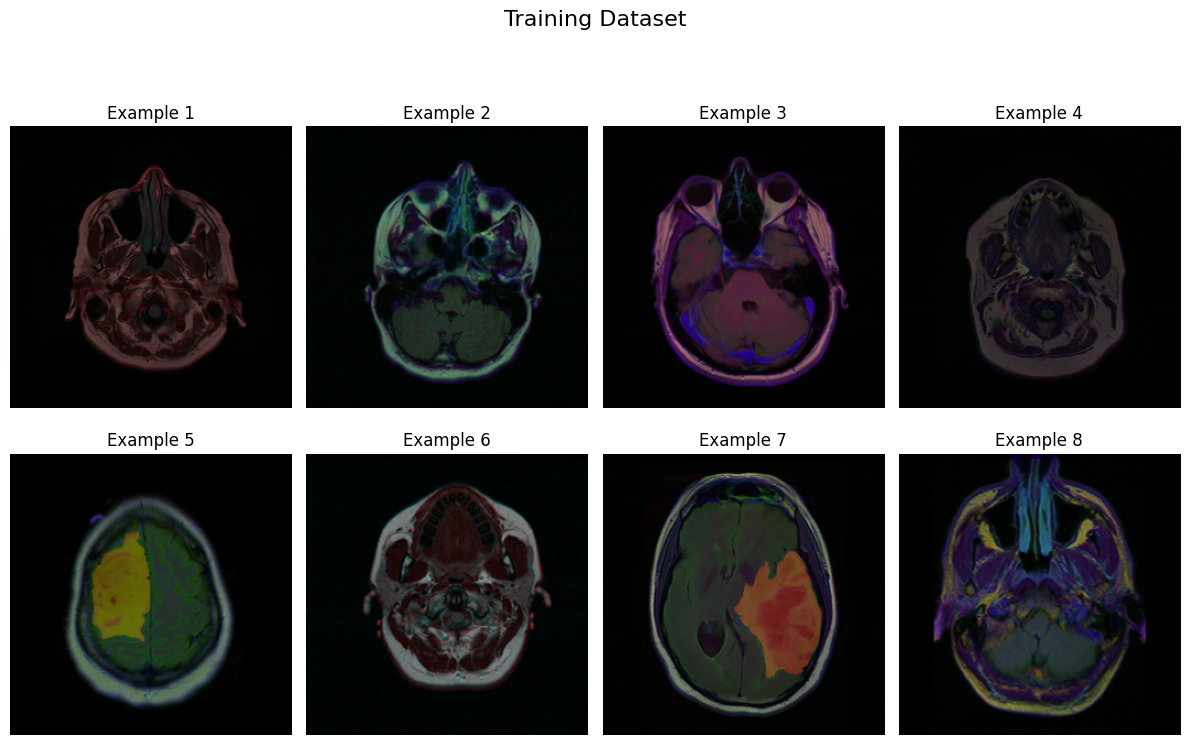

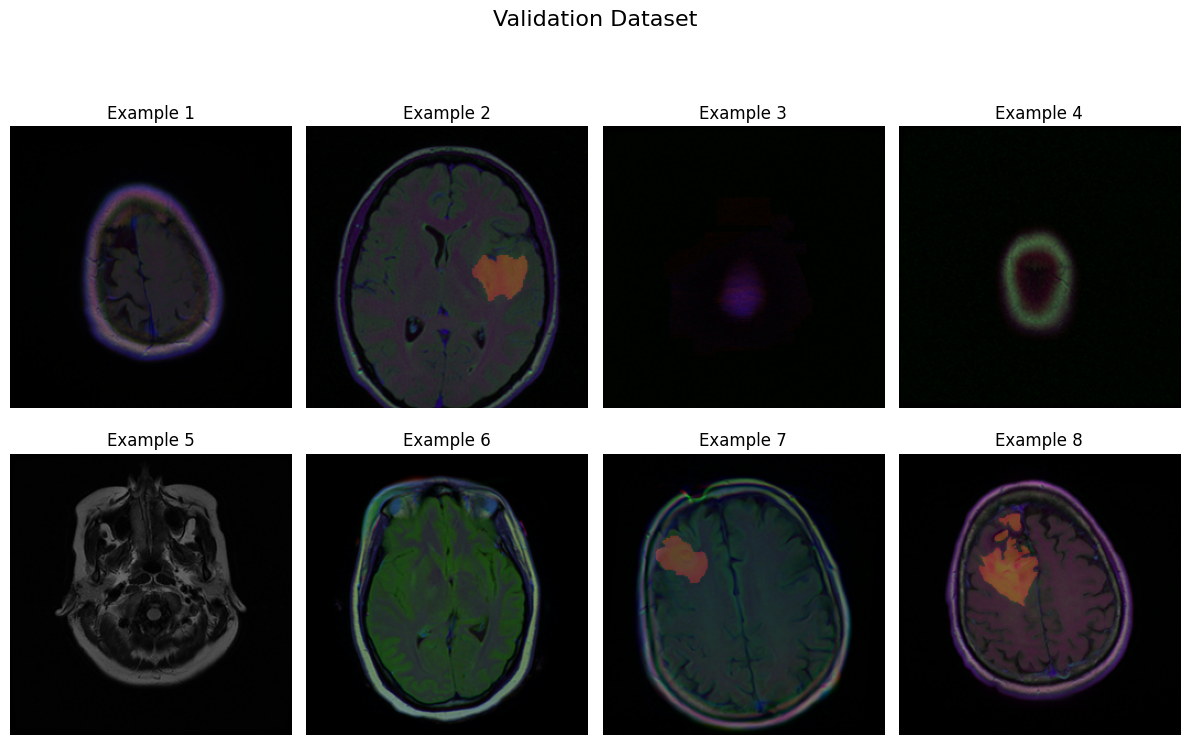

In [7]:
def display_batch(dataset, title="Dataset Batch"):
    plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)
    
    for images, masks in dataset.take(1):
        for i in range(min(8, len(images))):
            plt.subplot(2, 4, i+1)
            plt.imshow(images[i])
            
            # Overlay mask
            mask_overlay = np.zeros_like(images[i].numpy())
            mask_overlay[:, :, 0] = tf.squeeze(masks[i]).numpy()
            plt.imshow(mask_overlay, alpha=0.3)
            
            plt.title(f"Example {i+1}")
            plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


display_batch(train_dataset, "Training Dataset")

display_batch(val_dataset, "Validation Dataset")

In [8]:
def get_data_augmentation_model():
    
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomFlip("vertical"),
        RandomRotation(0.2),
        RandomZoom(0.2)
    ])
    return data_augmentation

Creating training and validation datasets...

Visualizing augmentations...
Found 3929 image-mask pairs


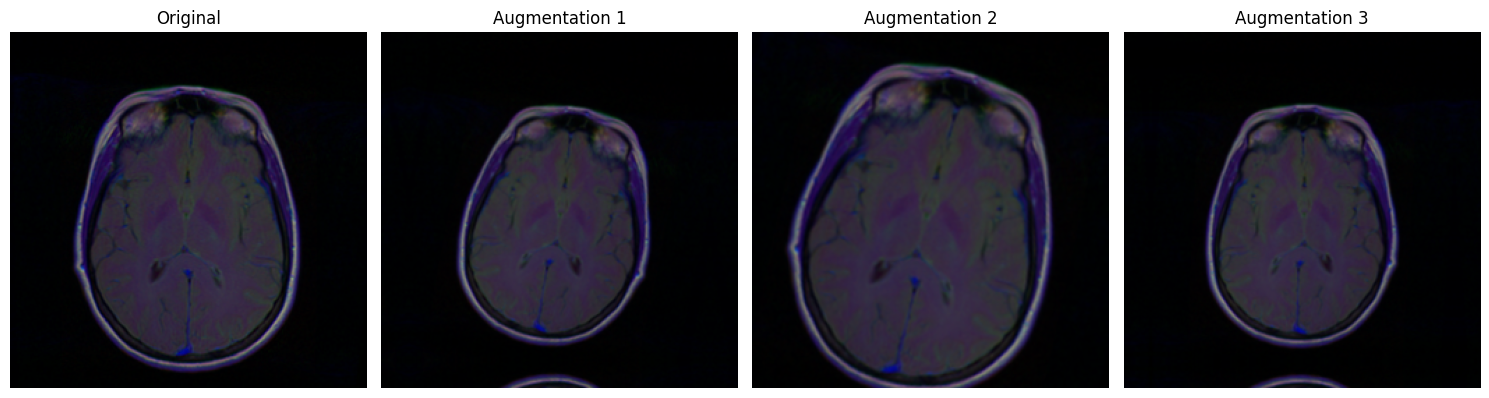

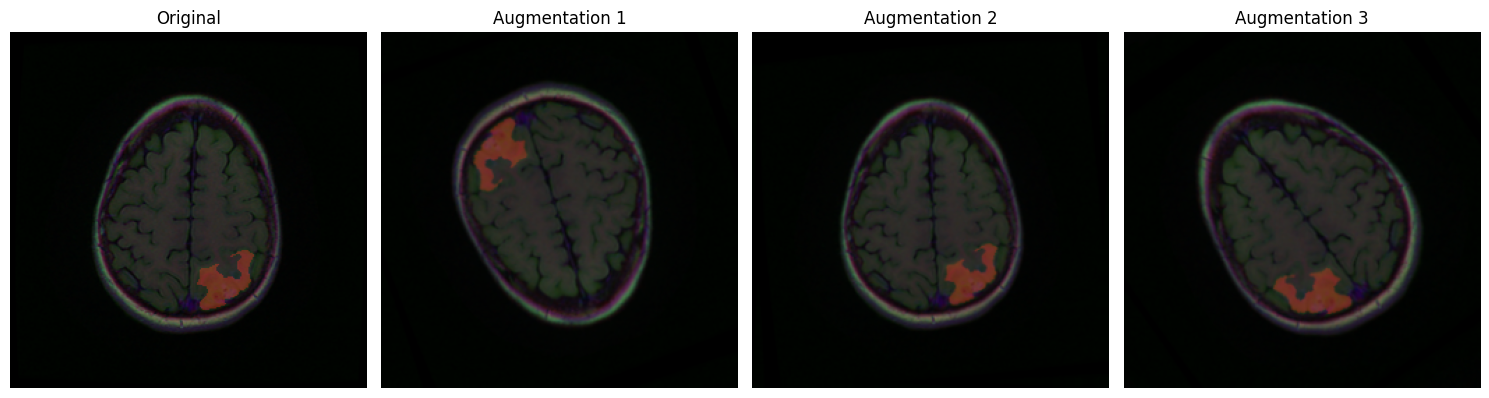

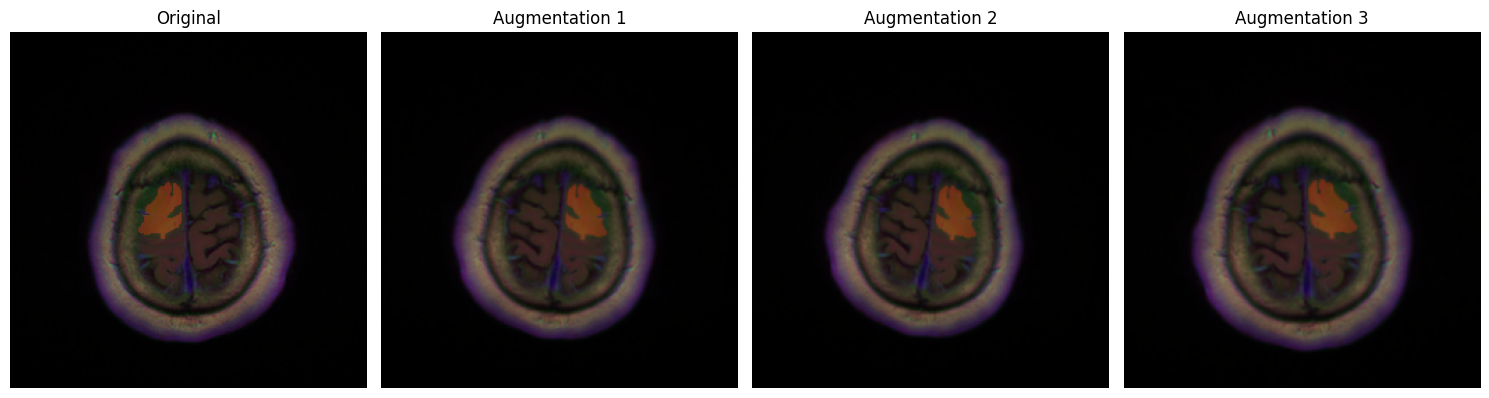

In [9]:
def visualize_simple_augmentations(num_examples=3):

    augmentation = get_data_augmentation_model()
    
    pairs = get_image_mask_pairs()
    if len(pairs) == 0:
        print("No image-mask pairs found!")
        return
    
    # Select random pairs
    selected_indices = np.random.choice(len(pairs), num_examples, replace=False)
    selected_pairs = [pairs[i] for i in selected_indices]
    
    for img_path, mask_path in selected_pairs:
        # Load original image and mask
        img = np.array(Image.open(img_path)) / 255.0
        mask = np.array(Image.open(mask_path)) / 255.0
        
        # Make sure mask has proper dimensions
        if len(mask.shape) > 2:
            mask = mask[:, :, 0]
        mask = mask[:, :, np.newaxis]
        
        # Convert to tensors
        img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
        mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
        
        # Combine for visualization (same transformations)
        combined = tf.concat([img_tensor, mask_tensor], axis=-1)
        
        # Display original and augmentations
        plt.figure(figsize=(15, 4))
        
        # Original
        plt.subplot(1, 4, 1)
        plt.imshow(img)
        
        # Overlay mask
        mask_overlay = np.zeros_like(img)
        mask_overlay[:, :, 0] = mask[:, :, 0]
        plt.imshow(mask_overlay, alpha=0.3)
        plt.title("Original")
        plt.axis('off')
        
        for i in range(3):
           
            augmented = augmentation(combined, training=True)
            
            # Split back
            aug_img = augmented[:, :, :3]
            aug_mask = augmented[:, :, 3:]
            
            # Display
            plt.subplot(1, 4, i+2)
            plt.imshow(aug_img)
            
            # Overlay mask
            mask_overlay = np.zeros_like(aug_img.numpy())
            mask_overlay[:, :, 0] = aug_mask[:, :, 0].numpy()
            plt.imshow(mask_overlay, alpha=0.3)
            plt.title(f"Augmentation {i+1}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

print("Creating training and validation datasets...")

# Visualize augmentations separately
print("\nVisualizing augmentations...")
visualize_simple_augmentations(num_examples = 3)

In [10]:
def weighted_dice_loss(y_true, y_pred):
    
    pos_weight = 20.0  
    
    # Add a small epsilon to avoid division by zero
    smooth = 1e-5
    
    # Flatten predictions and ground truth
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Apply class weighting
    weight_mask = y_true_f * (pos_weight - 1.0) + 1.0
    
    # Calculate weighted intersection and union
    weighted_intersection = tf.reduce_sum(weight_mask * y_true_f * y_pred_f)
    weighted_union = tf.reduce_sum(weight_mask * y_true_f) + tf.reduce_sum(y_pred_f)
    
    # Calculate Dice coefficient
    dice = (2. * weighted_intersection + smooth) / (weighted_union + smooth)
    
    # Return Dice loss
    return 1 - dice

In [11]:
def create_unet_model():
    
    with strategy.scope():
        # Input layer
        inputs = Input(shape=(256, 256, 3))
        
        # Data augmentation (only applied during training)
        data_augmentation = tf.keras.Sequential([
            RandomFlip("horizontal"),
            RandomFlip("vertical"),
            RandomRotation(0.2),
            RandomZoom(0.2)
        ])
        
        # Apply augmentation
        x = data_augmentation(inputs)
        
        # Encoder Path
        # Block 1
        conv1 = Conv2D(64, 3, padding='same', activation = 'relu')(x)
        conv1 = BatchNormalization()(conv1)
        conv1 = Conv2D(64, 3, padding='same', activation = 'relu')(conv1)
        conv1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
        # Block 2
        conv2 = Conv2D(128, 3, padding='same', activation = 'relu')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Conv2D(128, 3, padding='same', activation = 'relu')(conv2)
        conv2 = BatchNormalization()(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        
        # Block 3
        conv3 = Conv2D(256, 3, padding='same', activation = 'relu')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Conv2D(256, 3, padding='same', activation = 'relu')(conv3)
        conv3 = BatchNormalization()(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        
        # Block 4
        conv4 = Conv2D(512, 3, padding='same', activation = 'relu')(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Conv2D(512, 3, padding='same', activation = 'relu')(conv4)
        conv4 = BatchNormalization()(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        
        # Bridge
        conv5 = Conv2D(1024, 3, padding='same', activation = 'relu')(pool4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Conv2D(1024, 3, padding='same', activation = 'relu')(conv5)
        conv5 = BatchNormalization()(conv5)
        drop5 = Dropout(0.5)(conv5)
        
        # Decoder Path
        # Block 6
        up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same', activation = 'relu')(drop5)
        concat6 = Concatenate(axis = 3)([drop4, up6])
        conv6 = Conv2D(512, 3, padding='same', activation = 'relu')(concat6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Conv2D(512, 3, padding='same', activation = 'relu')(conv6)
        conv6 = BatchNormalization()(conv6)
        
        # Block 7
        up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same', activation = 'relu')(conv6)
        concat7 = Concatenate(axis = 3)([conv3, up7])
        conv7 = Conv2D(256, 3, padding='same', activation = 'relu')(concat7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Conv2D(256, 3, padding='same', activation = 'relu')(conv7)
        conv7 = BatchNormalization()(conv7)
        
        # Block 8
        up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same', activation = 'relu')(conv7)
        concat8 = Concatenate(axis=3)([conv2, up8])
        conv8 = Conv2D(128, 3, padding='same', activation = 'relu')(concat8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Conv2D(128, 3, padding='same', activation = 'relu')(conv8)
        conv8 = BatchNormalization()(conv8)
        
        # Block 9
        up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same', activation = 'relu')(conv8)
        concat9 = Concatenate(axis=3)([conv1, up9])
        conv9 = Conv2D(64, 3, padding='same', activation = 'relu')(concat9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Conv2D(64, 3, padding='same', activation = 'relu')(conv9)
        conv9 = BatchNormalization()(conv9)
        
        # Output layer
        outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
        
        # Create model
        model = Model(inputs=inputs, outputs=outputs)
        
        # Compile model with weighted dice loss
        model.compile(
            optimizer = Adam(learning_rate = 1e-4),
            loss = weighted_dice_loss,  
            metrics=[
                'accuracy',
                tf.keras.metrics.IoU(
                    num_classes=2,
                    target_class_ids=[1],
                    name='iou'
                ),
                tf.keras.metrics.Precision(name = 'precision'),
                tf.keras.metrics.Recall(name = 'recall')
            ]
        )
        
        return model

In [12]:
def train_model(model, train_dataset, val_dataset, epochs=50):
    
    callbacks = [
        # Reduce learning rate when plateauing
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
    ]
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks
    )
    
    return history, model

In [13]:
model = create_unet_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 256, 256, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [14]:
history, trained_model = train_model(
    model = model,
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    epochs = 20
)

Epoch 1/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 202s 454ms/step - accuracy: 0.7076 - iou: 0.0191 - loss: 0.4272 - precision: 0.0324 - recall: 0.9180 - val_accuracy: 0.7935 - val_iou: 0.0581 - val_loss: 0.2123 - val_precision: 0.0484 - val_recall: 0.9899 - learning_rate: 1.0000e-04
Epoch 2/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 182s 464ms/step - accuracy: 0.8271 - iou: 0.0570 - loss: 0.2666 - precision: 0.0528 - recall: 0.8612 - val_accuracy: 0.8718 - val_iou: 0.0773 - val_loss: 0.0571 - val_precision: 0.0736 - val_recall: 0.9568 - learning_rate: 1.0000e-04
Epoch 3/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 183s 467ms/step - accuracy: 0.8478 - iou: 0.0585 - loss: 0.2665 - precision: 0.0569 - recall: 0.8460 - val_accuracy: 0.8681 - val_iou: 0.0742 - val_loss: 0.0648 - val_precision: 0.0720 - val_recall: 0.9617 - learning_rate: 1.0000e-04
Epoch 4/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 184s 469ms/step - accuracy: 0.8600 - iou: 0.0594 - loss: 0.2370 - precision: 0.0587 - recall: 0.8508 - val_accuracy: 0.9385 - val_iou: 0.1

In [15]:

def visualize_training_history(history):

    plt.figure(figsize=(16, 6))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot IoU
    plt.subplot(1, 3, 2)
    plt.plot(history.history['iou'], label='Training IoU')
    plt.plot(history.history['val_iou'], label='Validation IoU')
    plt.title('Intersection over Union (IoU)')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    # Plot Precision and Recall
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



In [16]:
def visualize_predictions(model, dataset, num_examples=5):
    
    images = None
    masks = None
    
    # Get the first batch
    for img_batch, mask_batch in dataset.take(1):
        images = img_batch
        masks = mask_batch
        break
    
    if images is None or masks is None:
        print("ERROR: Could not get images and masks from dataset")
        return
    
    predictions = model.predict(images)
    
    print(f"Prediction stats: min={np.min(predictions):.6f}, max={np.max(predictions):.6f}, mean={np.mean(predictions):.6f}")
    print(f"Mask stats: min={np.min(masks.numpy()):.6f}, max={np.max(masks.numpy()):.6f}, mean={np.mean(masks.numpy()):.6f}")
    
    # Display results
    plt.figure(figsize=(15, 5 * min(num_examples, len(images))))
    
    for i in range(min(num_examples, len(images))):
        # Display original image
        plt.subplot(num_examples, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title(f"Original Image {i+1}")
        plt.axis('off')
        
        # Display ground truth mask
        plt.subplot(num_examples, 3, i*3 + 2)
        mask_display = tf.squeeze(masks[i]).numpy()
        plt.imshow(mask_display, cmap='viridis')
        plt.title(f"True Mask (sum={np.sum(mask_display):.1f})")
        plt.axis('off')
        
        # Display predicted mask
        plt.subplot(num_examples, 3, i*3 + 3)
        pred_display = tf.squeeze(predictions[i]).numpy()
        plt.imshow(pred_display, cmap='viridis')  # Viridis shows small values better than gray
        plt.title(f"Predicted Mask (sum={np.sum(pred_display):.1f})")
        plt.axis('off')
        
        plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(15, 5 * min(num_examples, len(images))))
    
    for i in range(min(num_examples, len(images))):
        
        plt.subplot(num_examples, 2, i*2 + 1)
        plt.imshow(images[i])
        
        mask_overlay = np.zeros_like(images[i].numpy())
        mask_overlay[:, :, 0] = tf.squeeze(masks[i]).numpy() * 1.0  # Red channel
        plt.imshow(mask_overlay, alpha=0.5)
        plt.title(f"Image {i+1} with True Mask")
        plt.axis('off')
        
        
        plt.subplot(num_examples, 2, i*2 + 2)
        plt.imshow(images[i])
        
        # Overlay predicted mask in blue
        pred_overlay = np.zeros_like(images[i].numpy())
        pred_overlay[:, :, 2] = tf.squeeze(predictions[i]).numpy() * 1.0  # Blue channel
        plt.imshow(pred_overlay, alpha=0.5)
        plt.title(f"Image {i+1} with Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # If predictions are too low, show a thresholded version
    if np.max(predictions) < 0.1:
        print("WARNING: Predictions have very low values. Showing amplified visualization...")
        
        plt.figure(figsize=(15, 5 * min(num_examples, len(images))))
        
        for i in range(min(num_examples, len(images))):
            # Original image
            plt.subplot(num_examples, 2, i*2 + 1)
            plt.imshow(images[i])
            plt.title(f"Original Image {i+1}")
            plt.axis('off')
            
            # Amplified prediction
            plt.subplot(num_examples, 2, i*2 + 2)
            # Normalize predictions to [0,1] range for better visualization
            pred_norm = tf.squeeze(predictions[i]).numpy()
            if np.max(pred_norm) > 0:
                pred_norm = pred_norm / np.max(pred_norm)
            plt.imshow(pred_norm, cmap='hot')
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.title(f"Amplified Prediction (max actual value: {np.max(predictions[i]):.6f})")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

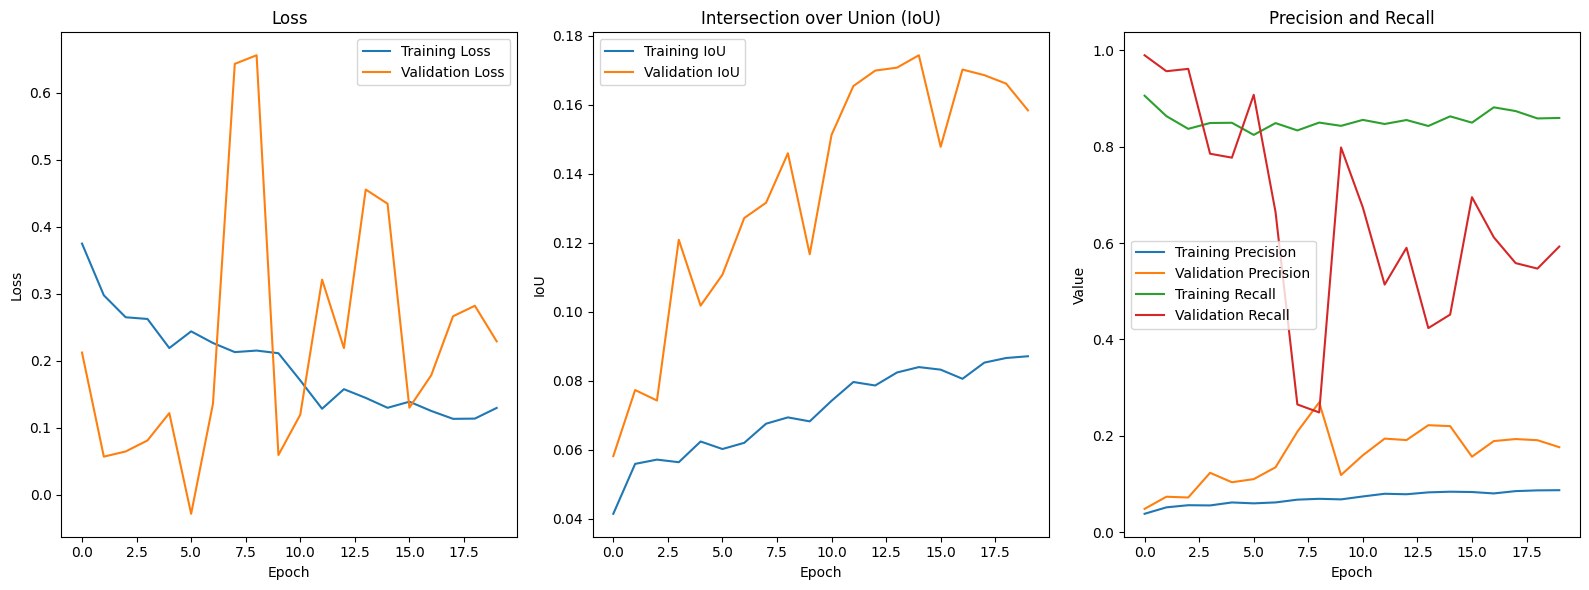

In [17]:
visualize_training_history(history)

In [20]:
import tensorflow.keras.backend as K
def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [23]:
def evaluate_model(model, test_dataset):
    dice_scores = []
    iou_scores = []

    for img_batch, mask_batch in test_dataset:
        preds = model.predict(img_batch)
        preds = (preds > 0.5).astype(np.float32)

        for i in range(len(img_batch)):
            dice = weighted_dice_loss(mask_batch[i], preds[i]).numpy()
            iou = iou_coef(mask_batch[i], preds[i]).numpy()

            dice_scores.append(dice)
            iou_scores.append(iou)

    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)

    metrics_df = pd.DataFrame({
        'Metric': ['Dice Coefficient', 'IoU'],
        'Score': [avg_dice, avg_iou]
    })

    print(metrics_df)

    return avg_dice, avg_iou

# Run evaluation
avg_dice, avg_iou = evaluate_model(model, test_dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Prediction stats: min=0.000002, max=1.000000, mean=0.017063
Mask stats: min=0.000000, max=1.000000, mean=0.013620


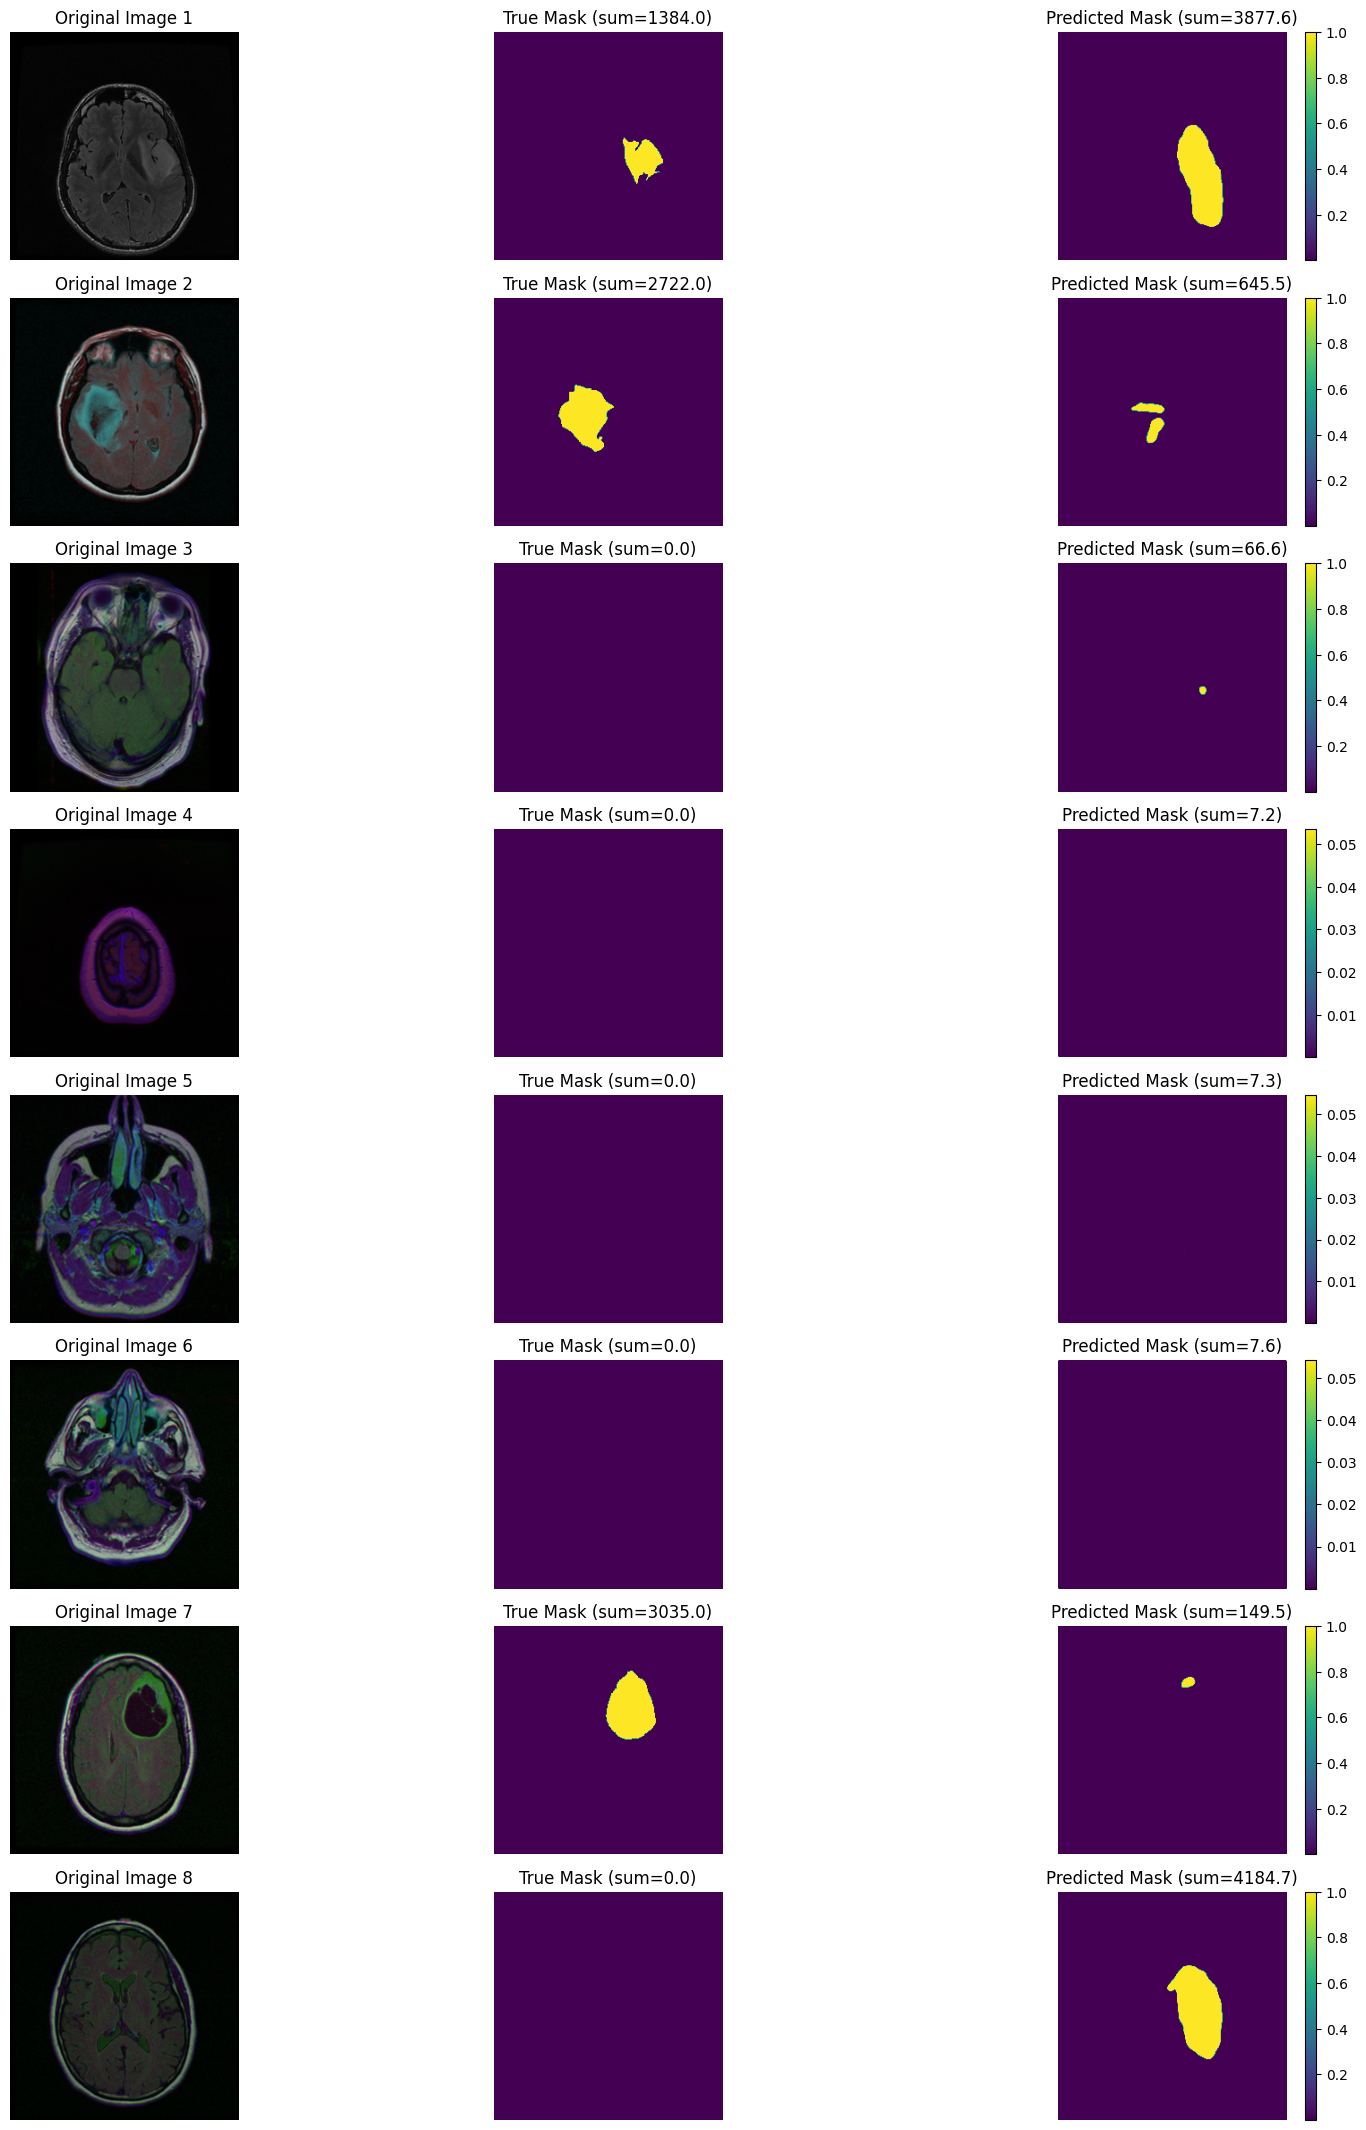

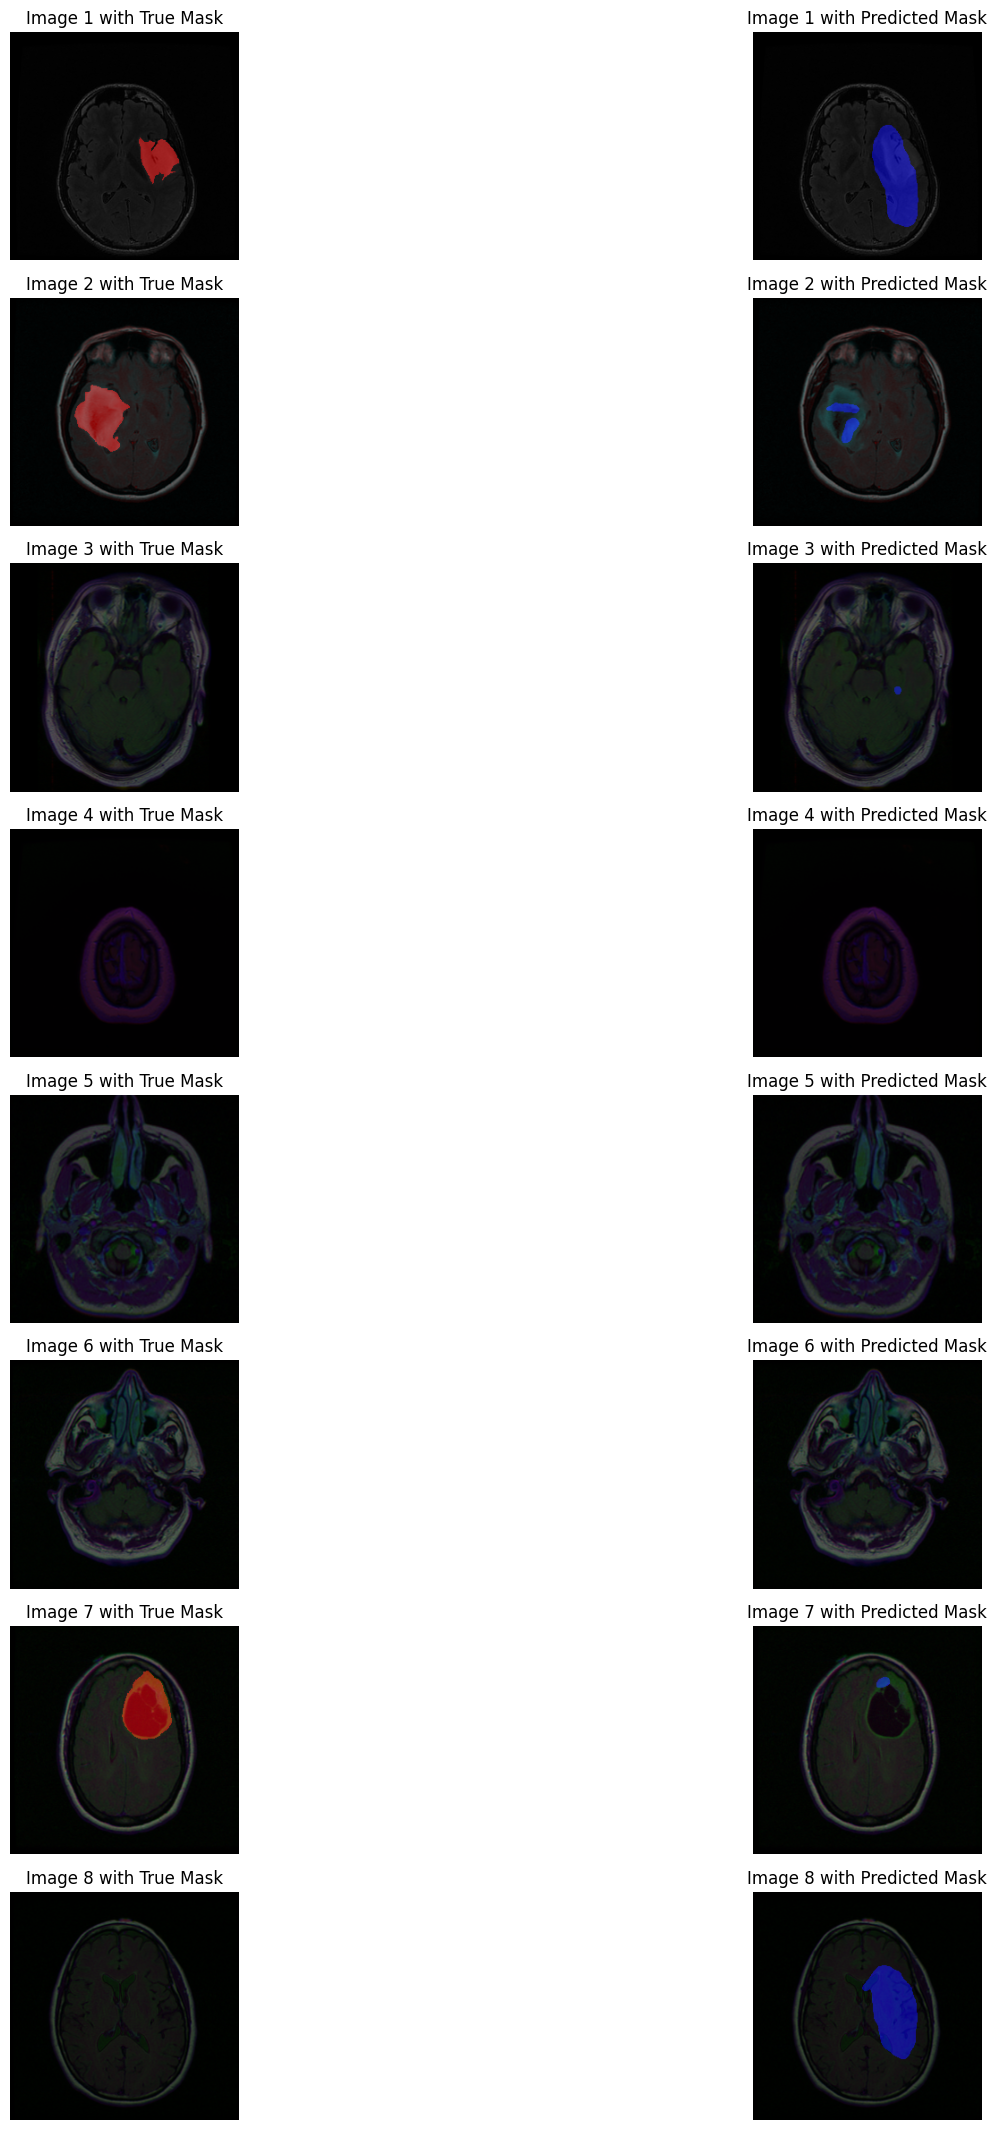

In [19]:
visualize_predictions(model, test_dataset, num_examples=15)